In [1]:
import json
import numpy as np
import torch
# Load model directly
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/home/wangyuxin//.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots")

def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

alpaca_data = load_json("/home/wangyuxin/xinhe/Sequence-Scheduling/data/alpaca-train-10k.json")

/mnt/raid/wangyuxin/miniconda3/envs/moe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
num_samples = len(alpaca_data)
data = {}
lengths = []
tokens = []
for i in range(num_samples):
    prompt = alpaca_data[i]['conversations'][0]['value']
    ids = tokenizer.encode(prompt)
    data[i] = {
        'prompt': prompt,
        'length': len(prompt.split(' ')),    
        'num_tokens': len(ids)    
    }
    lengths.append(len(prompt.split(' ')))
    tokens.append(len(ids))
print('text length', np.min(lengths), np.mean(lengths), np.max(lengths))
print('#tokens', np.min(tokens), np.mean(tokens), np.max(tokens))

text length 21 34.1237 287
#tokens 37 58.2928 384


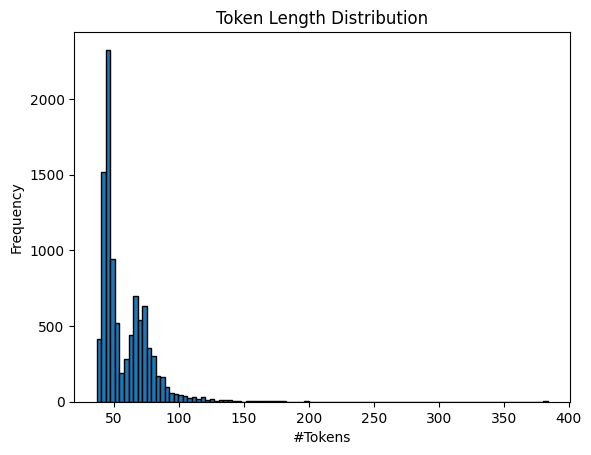

In [7]:
import matplotlib.pyplot as plt

# # 示例数据：替换成您的实际数据
# lengths = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# 对长度进行排序
sorted_lengths = sorted(tokens)

# 绘制直方图
plt.hist(sorted_lengths, bins=100, edgecolor='black')

# 添加标题和标签
plt.title('Token Length Distribution')
plt.xlabel('#Tokens')
plt.ylabel('Frequency')

# 显示图形
plt.show()


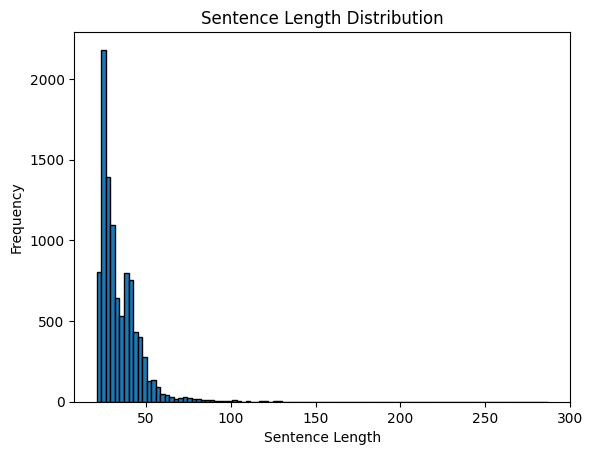

In [10]:
import matplotlib.pyplot as plt

# # 示例数据：替换成您的实际数据
# lengths = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# 对长度进行排序
sorted_lengths = sorted(lengths)

# 绘制直方图
plt.hist(sorted_lengths, bins=100, edgecolor='black')

# 添加标题和标签
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

# 显示图形
plt.show()


In [ ]:
import json
import numpy as np
import torch

def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

# data = load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_yizhongw.json')
# data = load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics.json')



In [ ]:
data = load_json("/home/nus-hx/code/Sequence-Scheduling/data/alpaca-train-10k.json")
data[1]['conversations'][0]['value']


'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nExplain why the following fraction is equivalent to 1/4\n\n### Input:\n4/16\n\n### Response:'

In [ ]:
def preprocess(data):
    all_num_tokens_per_expert = []
    # all_id_value_per_expert = []
    for layer_id, layer_expert_info in data.items():
        all_num_tokens_per_expert.append([])
        # all_id_value_per_expert.append([])
        for expert_idx, expert_info in layer_expert_info.items():
            all_num_tokens_per_expert[-1].append(expert_info[1:])
            # all_id_value_per_expert[-1].append(expert_info['id_value_per_expert'])
    return torch.tensor(all_num_tokens_per_expert)
    # return torch.tensor(all_num_tokens_per_expert), torch.tensor(all_id_value_per_expert)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_num_tokens(num_tokens, stpes=5):
    num_layers, num_experts, num_steps = num_tokens.shape
    num_steps = min(stpes, num_steps)
    # 创建一个子图，每个步骤一个子图
    fig, axs = plt.subplots(num_steps, 1, figsize=(num_experts, num_layers * num_steps))

    for step in range(num_steps):
        matrix = num_tokens[:, :, step]

        # 绘制热图
        im = axs[step].imshow(matrix, cmap='viridis')

        # 显示颜色条
        cbar = axs[step].figure.colorbar(im, ax=axs[step])

        # 设置坐标轴标签
        axs[step].set_xticks(np.arange(num_experts))
        axs[step].set_yticks(np.arange(num_layers))
        axs[step].set_xticklabels([f'Expert {i}' for i in range(num_experts)])
        axs[step].set_yticklabels([f'Layer {i}' for i in range(num_layers)])

        # 在矩阵元素上显示数值
        for i in range(num_layers):
            for j in range(num_experts):
                axs[step].text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='w')

        axs[step].set_title(f'Step {step + 1}')

    # 调整子图布局
    plt.tight_layout()
    plt.show()


In [ ]:
import torch

def kl_divergence(matrix1, matrix2, eps=1e-10):
    """
    计算两个矩阵每一行数据的KL散度（PyTorch版本）
    """
    # 将每一行的数据归一化为概率分布epsilon = 1e-10  # 或者选择适当的小值
    distributions1 = (matrix1 + eps) / torch.sum(matrix1 + eps, dim=1, keepdim=True)
    distributions2 = (matrix2 + eps) / torch.sum(matrix2 + eps, dim=1, keepdim=True)


    # 避免对数计算中出现无穷大值
    distributions1 = torch.where(torch.isnan(distributions1), torch.tensor(0.0), distributions1)
    distributions2 = torch.where(torch.isnan(distributions2), torch.tensor(0.0), distributions2)

    # 计算KL散度
    kl = torch.sum(distributions1 * torch.log(distributions1 / distributions2), dim=1)

    return kl


def jensen_shannon_divergence(matrix1, matrix2, epsilon=1e-10):
    # 将每一行的数据归一化为概率分布
    distributions1 = (matrix1 + epsilon) / (torch.sum(matrix1, dim=1, keepdim=True) + epsilon)
    distributions2 = (matrix2 + epsilon) / (torch.sum(matrix2, dim=1, keepdim=True) + epsilon)

    # 计算平均分布
    average_distribution = 0.5 * (distributions1 + distributions2)

    # 计算KL散度
    kl_divergence1 = torch.sum(distributions1 * torch.log(distributions1 / (average_distribution + epsilon)), dim=1)
    kl_divergence2 = torch.sum(distributions2 * torch.log(distributions2 / (average_distribution + epsilon)), dim=1)

    # 计算Jensen-Shannon散度
    js_divergence = 0.5 * (kl_divergence1 + kl_divergence2)
    similarity = 1 - 2 * js_divergence
    return js_divergence, similarity


In [ ]:
# use cache
data = load_json('/home/nus-hx/code/vllm/examples/4_expert_input_statistics.json')
num_tokens = preprocess(data) # (num_layers, num_experts, num_steps)
prefilling = num_tokens[..., 0]
decoding = num_tokens[..., 1:].sum(-1)
js, sim = jensen_shannon_divergence(prefilling, decoding)
# print(f"prefilling #tokens: {prefilling}")
# print(f"decoding #tokens: {decoding}")
print(f"js: {js.numpy()} 相似度: {sim}\n")

import numpy as np
from scipy.stats import spearmanr, pearsonr

# 创建两个示例矩阵
matrix1 = prefilling
matrix2 = decoding

# 计算Pearson相关系数
pearson_corr, _ = pearsonr(matrix1.flatten(), matrix2.flatten())
print(f"Pearson Correlation: {pearson_corr}")

# 计算Spearman等级相关系数
spearman_corr, _ = spearmanr(matrix1.flatten(), matrix2.flatten())
print(f"Spearman Rank Correlation: {spearman_corr}")

print(sim.mean())

js: [0.0535679  0.01546035 0.02906168 0.0134853  0.01635661 0.02407915
 0.06574866 0.1114352  0.08775527 0.08032545 0.02912238 0.02791613
 0.0416973  0.01863671 0.03236634 0.01655562 0.05890179 0.01565264
 0.02222927 0.01864578 0.077422   0.00626483 0.09608104 0.04317078
 0.04236926 0.03480298 0.03899682 0.02798922 0.03043891 0.01676919
 0.01555431 0.1200597 ] 相似度: tensor([0.8929, 0.9691, 0.9419, 0.9730, 0.9673, 0.9518, 0.8685, 0.7771, 0.8245,
        0.8393, 0.9418, 0.9442, 0.9166, 0.9627, 0.9353, 0.9669, 0.8822, 0.9687,
        0.9555, 0.9627, 0.8452, 0.9875, 0.8078, 0.9137, 0.9153, 0.9304, 0.9220,
        0.9440, 0.9391, 0.9665, 0.9689, 0.7599])

Pearson Correlation: 0.2905695381201951
Spearman Rank Correlation: 0.20819448895491566
tensor(0.9169)


In [ ]:
plot_num_tokens(num_tokens, 10)


In [ ]:
for i in range(1, 10):
    data = load_json(f'/home/nus-hx/code/ColossalAI/examples/language/openmoe/{i}_expert_input_statistics.json')
    num_tokens, id_values = preprocess(data) # (num_layers, num_experts, num_steps)
    prefilling = num_tokens[..., 0]
    decoding = num_tokens[..., 1:].sum(-1)
    js, sim = jensen_shannon_divergence(prefilling, decoding)
    print(f"{i}-th sample:")
    print(f"prefilling #tokens: {prefilling}")
    print(f"decoding #tokens: {decoding}")
    print(f"js: {js.numpy()} 相似度: {sim}\n")

1-th sample:
prefilling #tokens: tensor([[ 0.,  0., 36., 24., 12., 32., 26., 28., 39., 19., 29., 25., 24., 16.,
         33., 29.],
        [ 0.,  0., 13., 26., 28., 25., 37., 17., 30., 16., 25., 45., 18., 24.,
         30., 38.],
        [ 0.,  0.,  5., 26.,  6., 58., 34., 37., 34.,  8., 28., 27., 38., 38.,
         16., 17.]])
decoding #tokens: tensor([[ 0.,  0.,  0.,  0.,  0., 62.,  0.,  0., 62.,  0.,  1.,  0.,  0.,  0.,
          0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 62.,  0.,  1.,  0.,  0.,
         62.,  0.],
        [ 0.,  0., 62.,  0.,  1.,  0.,  5., 57.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.]])
js: [0.40641308 0.4757843  0.47032437] 相似度: tensor([0.1872, 0.0484, 0.0594])

2-th sample:
prefilling #tokens: tensor([[ 0.,  0.,  3.,  4.,  3.,  4.,  6.,  3., 14.,  4.,  8.,  3.,  5.,  6.,
          4.,  9.],
        [ 0.,  0.,  3.,  6., 10.,  9.,  5.,  4.,  1.,  3., 11.,  8.,  6.,  7.,
          3.,  0.],
        [ 0.,  0.,  1.,  0.,  0., 12.,  6., 

In [ ]:
plot_num_tokens(num_tokens, 10)

[[ 0.  0. 11.  7.  9. 31.  0.  6. 33.  3.  2.  5.  6.  6.  2.  5.]
 [ 0.  0.  6.  6.  2.  6.  8.  3.  6. 31.  8.  4.  2.  3. 37.  4.]
 [ 0.  0. 35.  0.  2.  9. 13. 10. 28.  3.  0.  5.  3.  8.  3.  7.]]


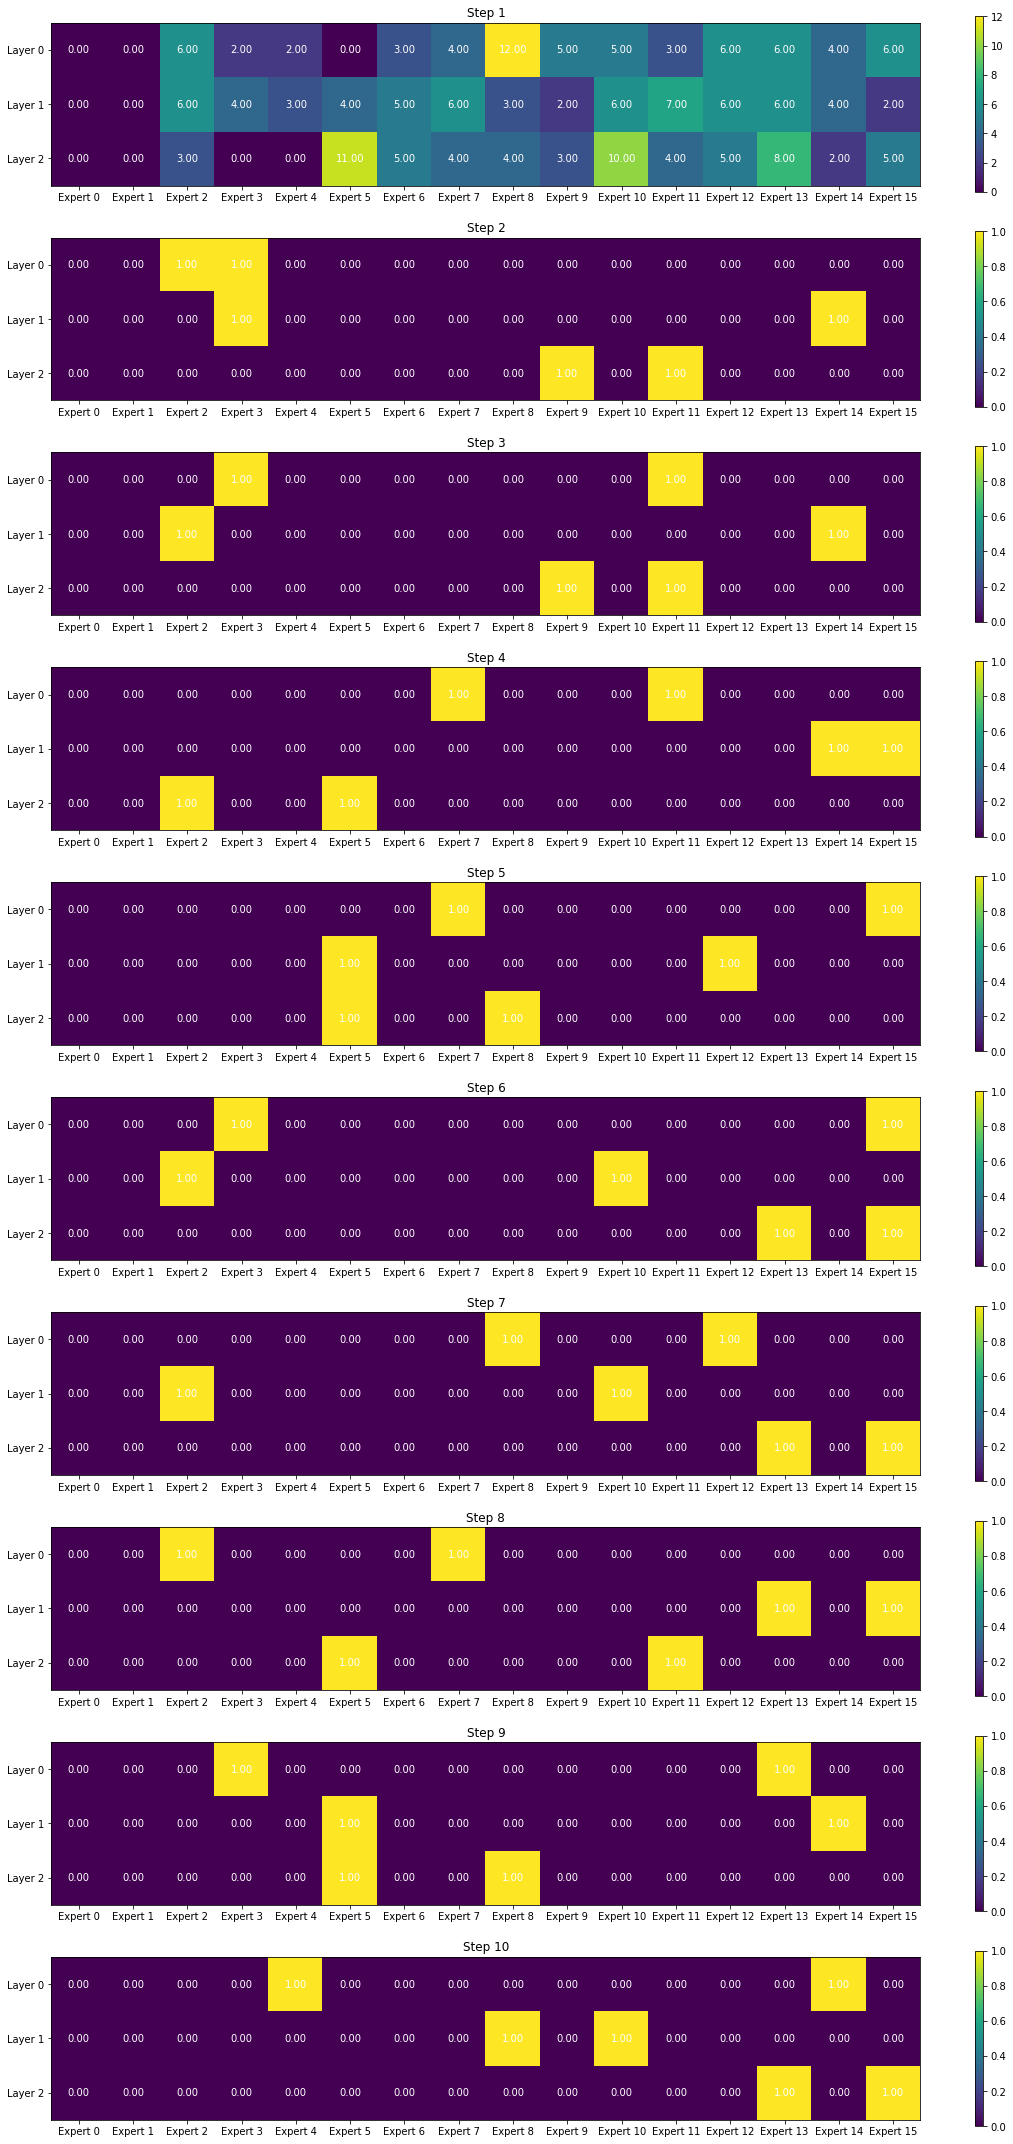

## use cache
data = load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_no_cache.json')
num_tokens, id_values = preprocess(data)
for step in range(10):
    print(num_tokens[0,:,step].numpy(), num_tokens[0,:,step].numpy().sum())

In [ ]:
def preprocess(data):
    id_means = []
    id_stds = []
    for layer_id, layer_expert_info in data.items():
        id_means.append([])
        id_stds.append([])
        for expert_idx, expert_info in layer_expert_info.items():
            id_means[-1].append(np.mean(expert_info))
            id_stds[-1].append(np.std(expert_info))
    id_means, id_stds = np.array(id_means), np.array(id_stds)
#     print('means:\n', id_means)
#     print('stds:\n', id_stds)
    return id_means, id_stds

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_variance(matrix_mean, matrix_var, is_sort=True):
    if is_sort:
        # 对均值矩阵按行排序
        sorted_indices = np.argsort(matrix_mean, axis=1)
        sorted_matrix_mean = np.take_along_axis(matrix_mean, sorted_indices, axis=1)
        sorted_matrix_var = np.take_along_axis(matrix_var, sorted_indices, axis=1)
    else:
        sorted_matrix_mean = matrix_mean
        sorted_matrix_var = matrix_var

    num_layers, num_experts = sorted_matrix_mean.shape

    plt.figure(figsize=(10, 6 * num_layers))  # 设置图表尺寸，每一层一个子图

    for layer in range(num_layers):
        plt.subplot(num_layers, 1, layer + 1)  # 创建子图
        mean_values = sorted_matrix_mean[layer]  # 获取当前层的均值
        var_values = sorted_matrix_var[layer]  # 获取当前层的方差

        # 绘制图表，均值用条形图表示，方差用error bar表示
        plt.bar(np.arange(num_experts), mean_values, yerr=var_values, capsize=5)
        plt.xlabel('Expert Index')
        plt.ylabel('Mean Value')
        plt.title(f'Layer {layer + 1}')

    plt.tight_layout()  # 调整布局
    plt.show()

# # 测试示例
# num_layer = 4
# num_expert = 6
# matrix_mean = np.random.randint(1, 50, size=(num_layer, num_expert))  # 生成随机均值矩阵
# matrix_var = np.random.randint(1, 20, size=(num_layer, num_expert))  # 生成随机方差矩阵
# print("原始均值矩阵：")
# print(matrix_mean)
# print("原始方差矩阵：")
# print(matrix_var)
# plot_mean_variance(matrix_mean, matrix_var, is_sort=False)


In [ ]:
data_yizhongw = preprocess(load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_yizhongw.json'))
# data_wikitext = preprocess(load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_wikitext.json'))
data_wikitext = preprocess(load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics.json'))

/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, i

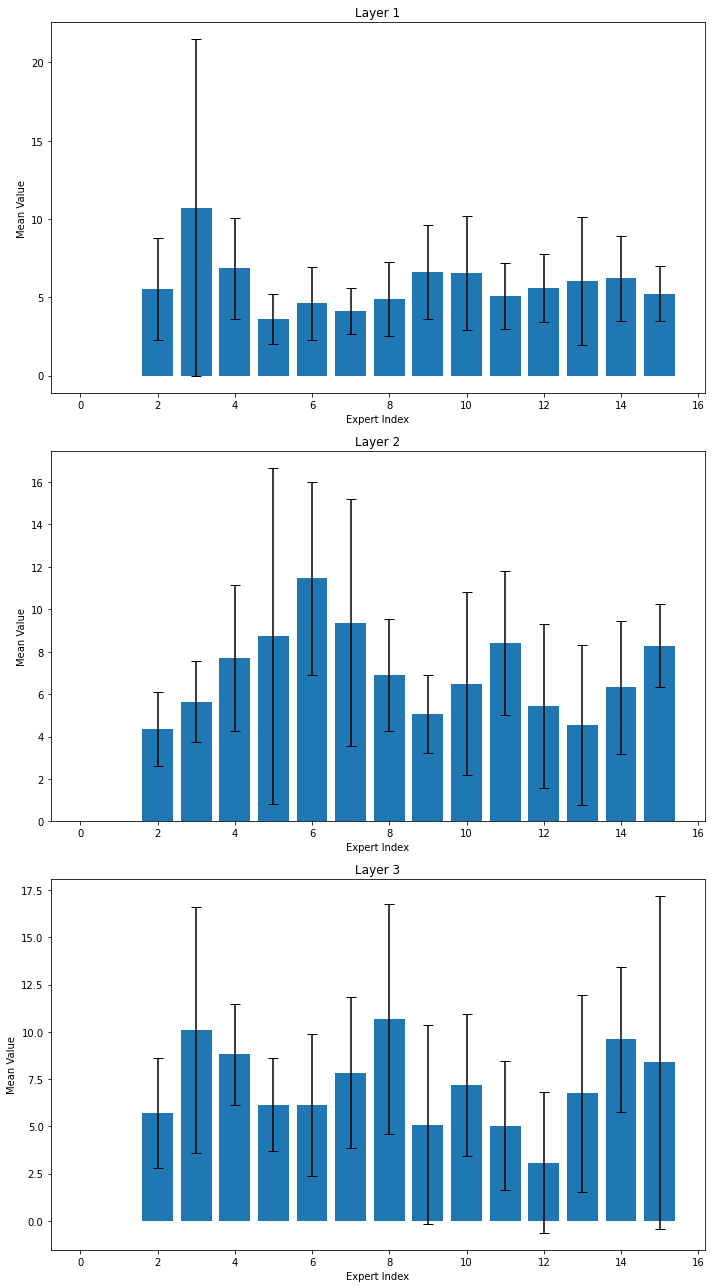

In [ ]:
plot_mean_variance(*data_yizhongw, False)

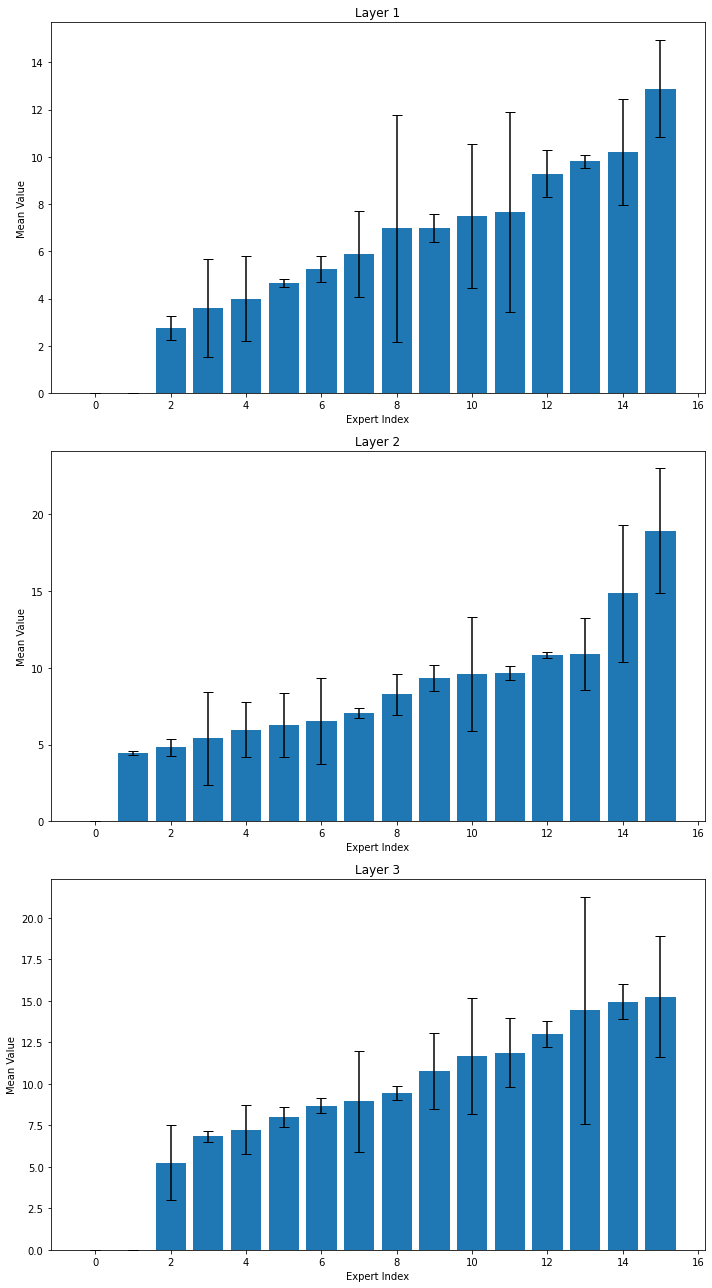

In [ ]:
plot_mean_variance(*data_wikitext, True)

原始矩阵：
[[ 0.        0.        5.544073 10.722609  6.840683  3.627592  4.612808
   4.135404  4.916871  6.61953   6.562585  5.101259  5.618176  6.03778
   6.207156  5.236032]
 [ 0.        0.        4.355231  5.640529  7.701429  8.725691 11.453165
   9.376528  6.904047  5.065467  6.500171  8.404157  5.460723  4.534373
   6.314137  8.272322]
 [ 0.        0.        5.698514 10.105216  8.807961  6.142078  6.140738
   7.836411 10.673695  5.086765  7.178852  5.035629  3.078635  6.750798
   9.594976  8.384435]]
排序后矩阵：
 [[ 0.        0.        3.627592  4.135404  4.612808  4.916871  5.101259
   5.236032  5.544073  5.618176  6.03778   6.207156  6.562585  6.61953
   6.840683 10.722609]
 [ 0.        0.        4.355231  4.534373  5.065467  5.460723  5.640529
   6.314137  6.500171  6.904047  7.701429  8.272322  8.404157  8.725691
   9.376528 11.453165]
 [ 0.        0.        3.078635  5.035629  5.086765  5.698514  6.140738
   6.142078  6.750798  7.178852  7.836411  8.384435  8.807961  9.594976
  10.105

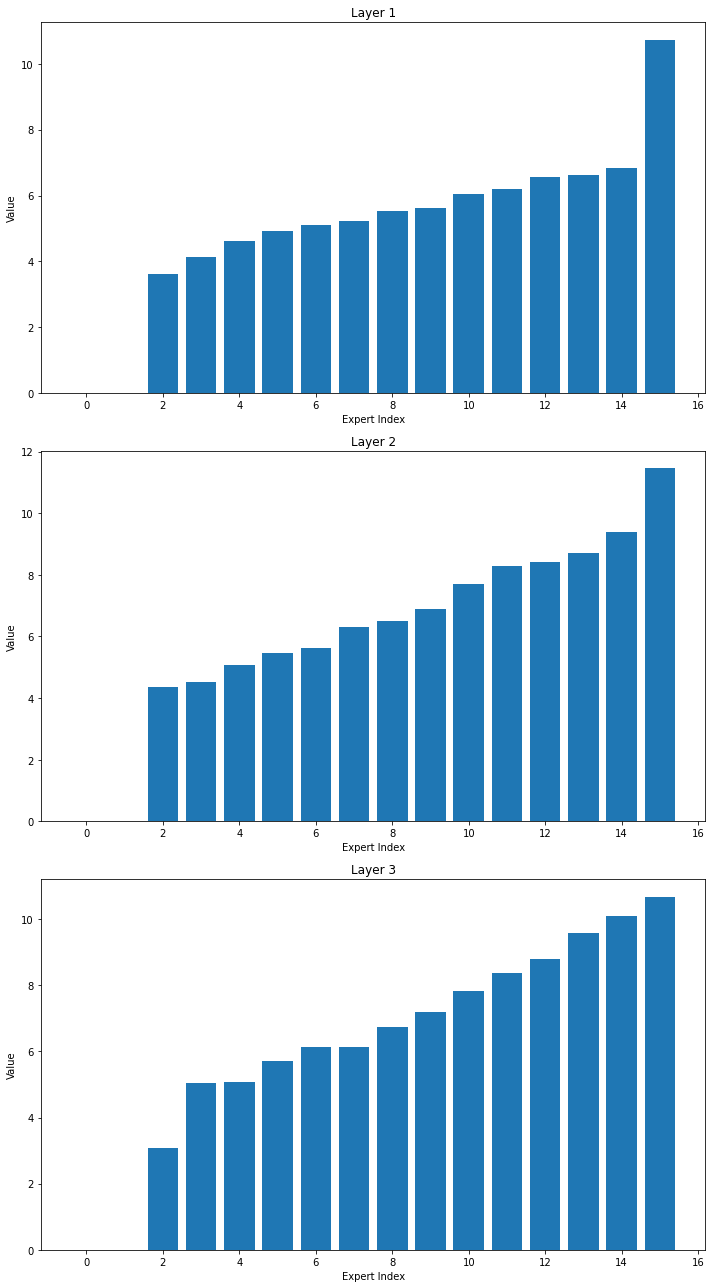

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_expert_values(matrix, to_sort=False):
    sorted_matrix = matrix
    if to_sort:
        sorted_matrix = np.sort(matrix, axis=1)  # 对矩阵按行排序
        print(f"排序后矩阵：\n", sorted_matrix)

    num_layers, num_experts = sorted_matrix.shape

    plt.figure(figsize=(10, 6 * num_layers))  # 设置图表尺寸，每一层一个子图

    for layer in range(num_layers):
        plt.subplot(num_layers, 1, layer + 1)  # 创建子图
        values = sorted_matrix[layer]  # 获取当前层的数值

        # 绘制图表
        plt.bar(np.arange(num_experts), values)
        plt.xlabel('Expert Index')
        plt.ylabel('Value')
        plt.title(f'Layer {layer + 1}')

    plt.tight_layout()  # 调整布局
    plt.show()

# 测试示例
num_layer = 4
num_expert = 6
matrix = np.random.randint(1, 50, size=(num_layer, num_expert))  # 生成随机矩阵


# results on yizhongw
matrix = [   
    [0,0,5.544073,10.722609,6.840683,3.627592,4.612808,4.135404,4.916871,6.619530,6.562585,5.101259,5.618176,6.037780,6.207156,5.236032],
    [0,0,4.355231,5.640529,7.701429,8.725691,11.453165,9.376528,6.904047,5.065467,6.500171,8.404157,5.460723,4.534373,6.314137,8.272322],
    [0,0,5.698514,10.105216,8.807961,6.142078,6.140738,7.836411,10.673695,5.086765,7.178852,5.035629,3.078635,6.750798,9.594976,8.384435]
]
matrix = np.array(matrix)
matrix = np.nan_to_num(matrix)
print("原始矩阵：")
print(matrix)
plot_expert_values(matrix, True)


原始矩阵：
[[ 0.        0.        5.544073 10.722609  6.840683  3.627592  4.612808
   4.135404  4.916871  6.61953   6.562585  5.101259  5.618176  6.03778
   6.207156  5.236032]
 [ 0.        0.        4.355231  5.640529  7.701429  8.725691 11.453165
   9.376528  6.904047  5.065467  6.500171  8.404157  5.460723  4.534373
   6.314137  8.272322]
 [ 0.        0.        5.698514 10.105216  8.807961  6.142078  6.140738
   7.836411 10.673695  5.086765  7.178852  5.035629  3.078635  6.750798
   9.594976  8.384435]]
排序后矩阵：
 [[ 0.        0.        3.627592  4.135404  4.612808  4.916871  5.101259
   5.236032  5.544073  5.618176  6.03778   6.207156  6.562585  6.61953
   6.840683 10.722609]
 [ 0.        0.        4.355231  4.534373  5.065467  5.460723  5.640529
   6.314137  6.500171  6.904047  7.701429  8.272322  8.404157  8.725691
   9.376528 11.453165]
 [ 0.        0.        3.078635  5.035629  5.086765  5.698514  6.140738
   6.142078  6.750798  7.178852  7.836411  8.384435  8.807961  9.594976
  10.105

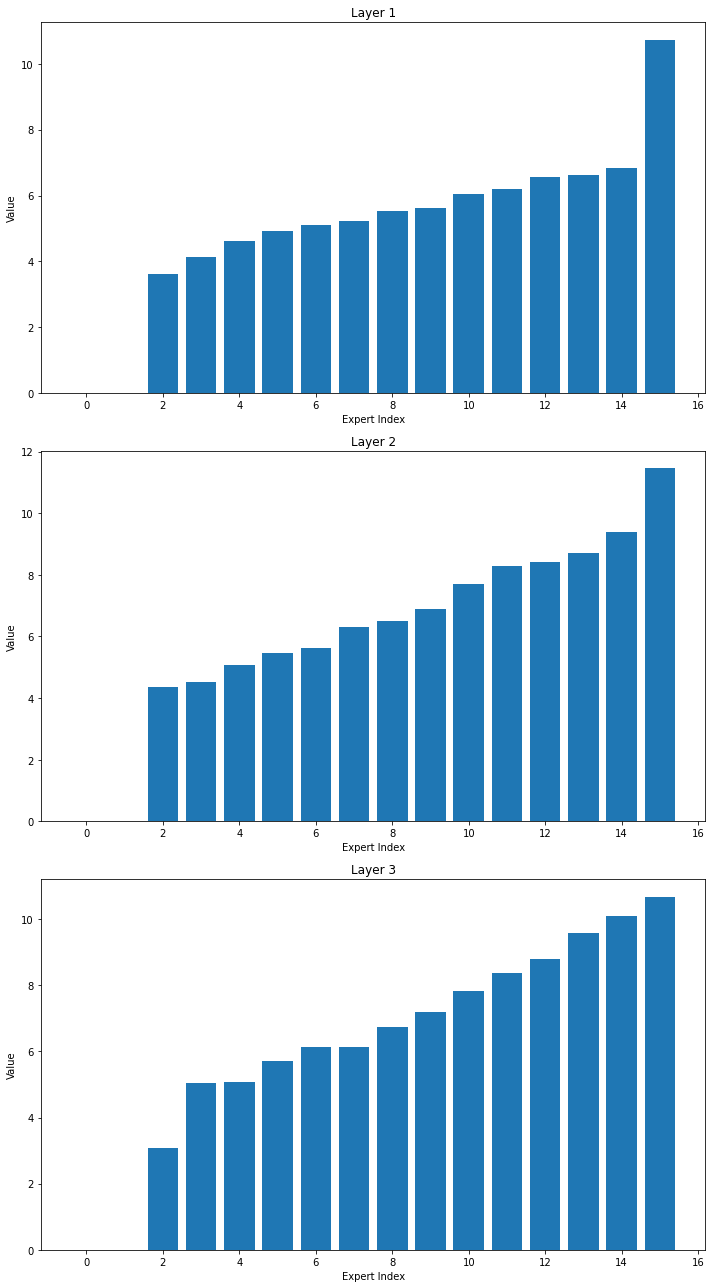

In [ ]:
matrix = [
    [0,0,5.544073,10.722609,6.840683,3.627592,4.612808,4.135404,4.916871,6.619530,6.562585,5.101259,5.618176,6.037780,6.207156,5.236032],
    [0,0,4.355231,5.640529,7.701429,8.725691,11.453165,9.376528,6.904047,5.065467,6.500171,8.404157,5.460723,4.534373,6.314137,8.272322],
    [0,0,5.698514,10.105216,8.807961,6.142078,6.140738,7.836411,10.673695,5.086765,7.178852,5.035629,3.078635,6.750798,9.594976,8.384435],
]

matrix = np.array(matrix)
matrix = np.nan_to_num(matrix)
print("原始矩阵：")
print(matrix)
plot_expert_values(matrix, True)

原始矩阵：
[[ 0.        0.        7.963334  7.24861   5.389153  5.79661   4.887456
   5.961907  5.427928  5.641143  3.553481  4.450169  6.972357  4.594432
   8.926065  7.169308]
 [ 0.       10.37379   6.114333 11.607411 11.788904 12.56812   9.828843
   9.701502  9.9606    5.349957  8.947469 11.169651  6.741775  8.415722
   8.856209  8.982792]
 [ 0.        0.        5.87593   7.778467  9.251879 11.587394 13.382789
  10.92747  10.783409  9.167251 11.630848  9.831821 13.27439   6.963855
  12.515475  8.359204]]


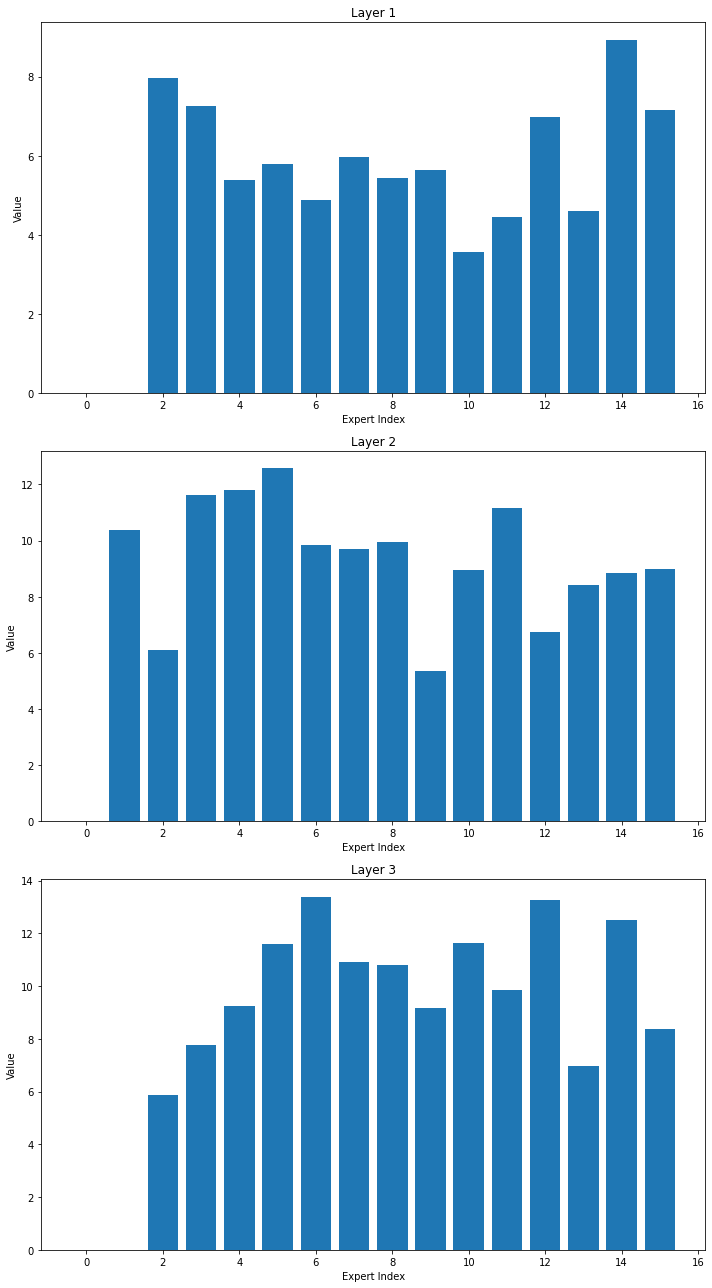

In [ ]:
# results on Wikitext-2-v1

matrix = [
    [0.000000,0.000000,7.963334,7.248610,5.389153,5.796610,4.887456,5.961907,5.427928,5.641143,3.553481,4.450169,6.972357,4.594432,8.926065,7.169308],
[0.000000,10.373790,6.114333,11.607411,11.788904,12.568120,9.828843,9.701502,9.960600,5.349957,8.947469,11.169651,6.741775,8.415722,8.856209,8.982792],
[0.000000,0.000000,5.875930,7.778467,9.251879,11.587394,13.382789,10.927470,10.783409,9.167251,11.630848,9.831821,13.274390,6.963855,12.515475,8.359204]
]

matrix = np.array(matrix)
matrix = np.nan_to_num(matrix)
print("原始矩阵：")
print(matrix)
plot_expert_values(matrix)

排序后矩阵：
 [[ 0.        0.        3.553481  4.450169  4.594432  4.887456  5.389153
   5.427928  5.641143  5.79661   5.961907  6.972357  7.169308  7.24861
   7.963334  8.926065]
 [ 0.        5.349957  6.114333  6.741775  8.415722  8.856209  8.947469
   8.982792  9.701502  9.828843  9.9606   10.37379  11.169651 11.607411
  11.788904 12.56812 ]
 [ 0.        0.        5.87593   6.963855  7.778467  8.359204  9.167251
   9.251879  9.831821 10.783409 10.92747  11.587394 11.630848 12.515475
  13.27439  13.382789]]


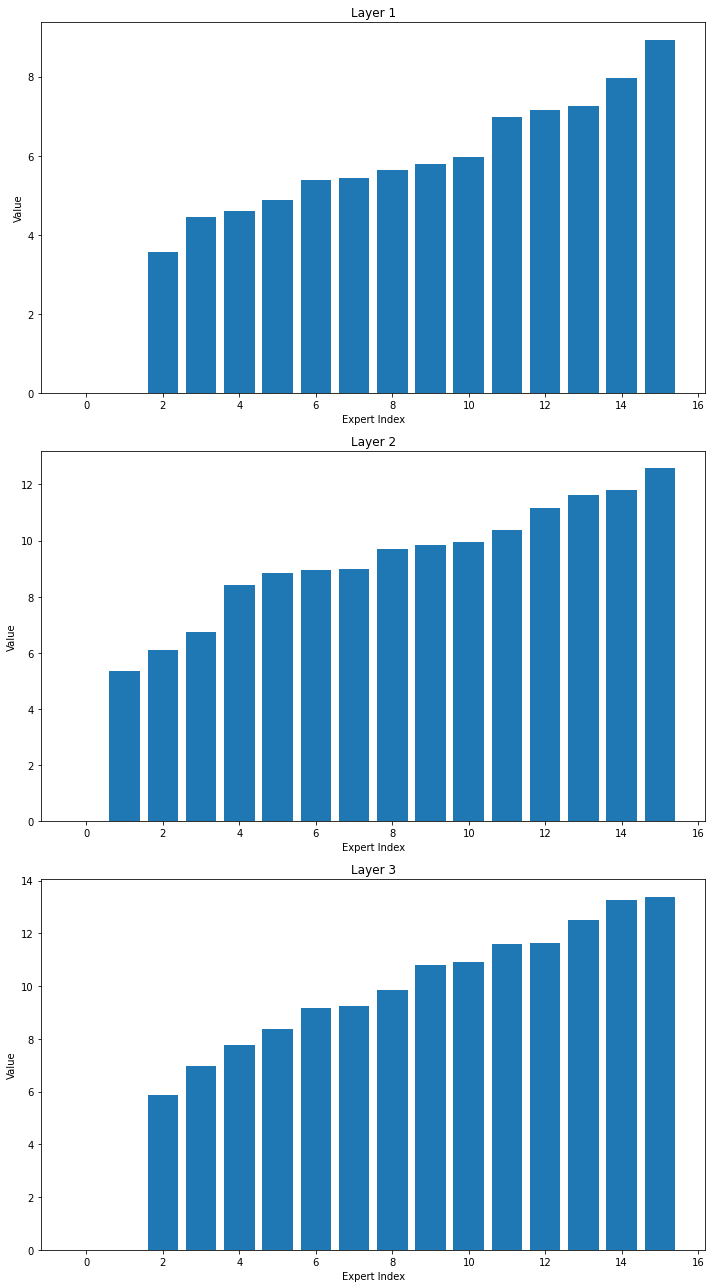

In [ ]:

plot_expert_values(matrix, True)